# fbprophet 모델을 활용한 인공지능 비트 트레이더 경진대회 베이스라인 코드

In [1]:
# !pip install statsmodels==0.11.1
# !pip install fbprophet
# !pip install plotly

# 1. Library Import

In [2]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
from plotly import tools 
import plotly.offline as offline 
import plotly.graph_objs as go 
warnings.filterwarnings("ignore")

In [3]:
gc.collect()

20

# 2. 데이터 불러오기

## 1) read_csv

In [3]:
data_path = os.getenv('HOME') + '/ModuWay/data' # 경로 다름! 변경해줘야함
# data_path = os.getenv('HOME') + '/ModuWay/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

* sample_id : 개별 샘플의 인덱스
* time : x_df는 0분 ~ 1379분, y_df는 0분 ~ 119분의 값을 갖습니다. 동일한 샘플 내 시간 정보
* coin_index : 10가지 종류의 코인에 대한 비식별화 인덱스 (0 ~9)
* open : open price
* high : high price
* low : low price
* open : open price
* volume : 거래량
* quote_av : quote asset volume
* trades : 거래 건 수
* tb_base_av : taker buy base asset volume
* tb_quote_av : taker buy quote asset volume

In [4]:
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [5]:
sma_3 = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['open'].rolling(window = 3, min_periods=1).mean())
sma_3.head()

open
sample_id                   
0         0         1.010004
          1         1.009906
          2         1.009873
          3         1.009938
          4         1.010331
...                      ...
7361      10159555  0.999666
          10159556  1.000598
          10159557  1.001196
          10159558  1.001210
          10159559  1.000668

[10159560 rows x 1 columns]

In [6]:
train_x_df.loc[:,'sma_3'] = sma_3['open'].values

In [7]:
sma_7 = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['open'].rolling(window = 7, min_periods=1).mean())
sma_7.head()

open
sample_id                   
0         0         1.010004
          1         1.009906
          2         1.009873
          3         1.009955
          4         1.010161
...                      ...
7361      10159555  0.998790
          10159556  0.999386
          10159557  0.999845
          10159558  1.000125
          10159559  1.000376

[10159560 rows x 1 columns]

In [8]:
train_x_df.loc[:,'sma_7'] = sma_7['open'].values

In [9]:
sma_25 = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['open'].rolling(window = 25, min_periods=1).mean())
sma_25.head()

open
sample_id                   
0         0         1.010004
          1         1.009906
          2         1.009873
          3         1.009955
          4         1.010161
...                      ...
7361      10159555  0.998176
          10159556  0.998226
          10159557  0.998304
          10159558  0.998332
          10159559  0.998322

[10159560 rows x 1 columns]

In [10]:
train_x_df.loc[:,'sma_25'] = sma_25['open'].values

In [11]:
# train_x_df에 macdo 지표 추가
train_x_df['ma_12'] = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['open'].transform(lambda x: x.ewm(span=12, min_periods=1).mean()))
train_x_df['ma_26'] = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['open'].transform(lambda x: x.ewm(span=26, min_periods=1).mean()))
train_x_df['macd'] = train_x_df['ma_12'] - train_x_df['ma_26'] # MACD 
train_x_df['macds'] = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['macd'].transform(lambda x: x.ewm(span=9, min_periods=1).mean()))# Signal 
train_x_df['macdo'] = train_x_df['macd'] - train_x_df['macds'] # Oscillator 

In [12]:
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma_3,sma_7,sma_25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594,1.010004,1.010004,1.010004,1.010004,1.010004,0.000000,0.000000e+00,0.000000
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000,1.009906,1.009906,1.009906,1.009898,1.009902,-0.000004,-2.445743e-06,-0.000002
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808,1.009873,1.009873,1.009873,1.009863,1.009868,-0.000006,-3.742345e-06,-0.000002
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875,1.009938,1.009955,1.009955,1.009969,1.009961,0.000008,2.840201e-07,0.000008
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000,1.010331,1.010161,1.010161,1.010245,1.010198,0.000047,1.408210e-05,0.000033


In [13]:
train_y_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,42356.179688,137.308746,8.305119e+05,42356.179688
1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,27140.638672,294.233032,4.882738e+05,24909.861328
2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,26100.681641,58.846603,5.113770e+05,26100.681641
3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,57929.410156,137.308746,1.095514e+06,55921.156250
4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,295872.343750,666.928162,9.911239e+05,50528.589844


In [14]:
sma_3 = pd.DataFrame(train_y_df.groupby(train_y_df['sample_id'])['open'].rolling(window = 3, min_periods=1).mean())
sma_3.head()

open
sample_id                 
0         0       1.000392
          1       1.000490
          2       1.000719
          3       1.000981
          4       1.001112
...                    ...
7361      883435  1.006663
          883436  1.007136
          883437  1.007831
          883438  1.008290
          883439  1.008791

[883440 rows x 1 columns]

In [15]:
train_y_df.loc[:,'sma_3'] = sma_3['open'].values

In [16]:
sma_7 = pd.DataFrame(train_y_df.groupby(train_y_df['sample_id'])['open'].rolling(window = 7, min_periods=1).mean())
sma_7.head()

open
sample_id                 
0         0       1.000392
          1       1.000490
          2       1.000719
          3       1.000834
          4       1.000863
...                    ...
7361      883435  1.006045
          883436  1.006402
          883437  1.006838
          883438  1.007207
          883439  1.007720

[883440 rows x 1 columns]

In [17]:
train_y_df.loc[:,'sma_7'] = sma_7['open'].values

In [18]:
sma_25 = pd.DataFrame(train_y_df.groupby(train_y_df['sample_id'])['open'].rolling(window = 25, min_periods=1).mean())
sma_25.head()

open
sample_id                 
0         0       1.000392
          1       1.000490
          2       1.000719
          3       1.000834
          4       1.000863
...                    ...
7361      883435  1.006174
          883436  1.006186
          883437  1.006264
          883438  1.006328
          883439  1.006411

[883440 rows x 1 columns]

In [19]:
train_y_df.loc[:,'sma_25'] = sma_25['open'].values

In [20]:
# train_y_df macdo 지표 추가
train_y_df['ma_12'] = pd.DataFrame(train_y_df.groupby(train_y_df['sample_id'])['open'].transform(lambda x: x.ewm(span=12, min_periods=1).mean()))
train_y_df['ma_26'] = pd.DataFrame(train_y_df.groupby(train_y_df['sample_id'])['open'].transform(lambda x: x.ewm(span=26, min_periods=1).mean()))
train_y_df['macd'] = train_y_df['ma_12'] - train_y_df['ma_26'] # MACD 
train_y_df['macds'] = pd.DataFrame(train_y_df.groupby(train_x_df['sample_id'])['macd'].transform(lambda x: x.ewm(span=9, min_periods=1).mean()))# Signal 
train_y_df['macdo'] = train_y_df['macd'] - train_y_df['macds'] # Oscillator 

In [21]:
train_y_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma_3,sma_7,sma_25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,42356.179688,137.308746,8.305119e+05,42356.179688,1.000392,1.000392,1.000392,1.000392,1.000392,0.000000,0.000000,0.000000
1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,27140.638672,294.233032,4.882738e+05,24909.861328,1.000490,1.000490,1.000490,1.000499,1.000494,0.000004,0.000002,0.000002
2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,26100.681641,58.846603,5.113770e+05,26100.681641,1.000719,1.000719,1.000719,1.000763,1.000739,0.000024,0.000011,0.000013
3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,57929.410156,137.308746,1.095514e+06,55921.156250,1.000981,1.000834,1.000834,1.000894,1.000862,0.000032,0.000018,0.000014
4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,295872.343750,666.928162,9.911239e+05,50528.589844,1.001112,1.000863,1.000863,1.000917,1.000889,0.000028,0.000021,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883435,7361,115,8,1.007303,1.007845,1.007261,1.007720,2.843995e+00,686.734558,0.792856,1.373841e+00,331.730499,1.006663,1.006045,1.006174,1.006138,1.006419,-0.000281,-0.000517,0.000236
883436,7361,116,8,1.007678,1.008847,1.007678,1.008471,2.577599e+00,622.798462,0.884660,1.638966e+00,396.005463,1.007136,1.006402,1.006186,1.006375,1.006512,-0.000137,-0.000441,0.000303
883437,7361,117,8,1.008513,1.009014,1.008304,1.008805,4.579865e+00,1106.928345,1.210149,1.735705e+00,419.485596,1.007831,1.006838,1.006264,1.006704,1.006661,0.000043,-0.000344,0.000387
883438,7361,118,8,1.008680,1.009222,1.008680,1.009222,1.065129e+00,257.542755,0.525789,4.348240e-01,105.134232,1.008290,1.007207,1.006328,1.007008,1.006810,0.000198,-0.000236,0.000433


In [22]:
test_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.968750,182543.687500,332.671570,287449.968750,107758.375000
1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.375000,309019.750000,407.790955,560290.250000,210005.125000
2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.562500,179301.843750,276.332031,214270.265625,80283.554688
3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.843750,125305.117188,166.335785,56401.246094,21135.490234
4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.687500,210316.796875,303.160370,138711.703125,52010.964844
...,...,...,...,...,...,...,...,...,...,...,...,...
730015,528,1375,5,1.001805,1.001805,0.998797,0.998797,583600.875000,77517.406250,473.898010,9092.824219,1210.823120
730016,528,1376,5,0.998571,1.001730,0.996690,1.001730,688827.312500,91420.523438,503.986786,289617.906250,38465.292969
730017,528,1377,5,0.999323,1.003009,0.997367,1.002934,417688.437500,55624.304688,353.542969,291073.437500,38773.152344
730018,528,1378,5,1.000903,1.000903,0.999774,0.999925,91273.515625,12139.500000,120.355049,0.000000,0.000000


In [23]:
sma_3 = pd.DataFrame(test_x_df.groupby(train_x_df['sample_id'])['open'].rolling(window = 3, min_periods=1).mean())
sma_3.head()

open
sample_id                 
0         0       1.003541
          1       1.004829
          2       1.005196
          3       1.005697
          4       1.005518
...                    ...
528       730015  0.998395
          730016  0.999022
          730017  0.999900
          730018  0.999599
          730019  1.000075

[730020 rows x 1 columns]

In [24]:
test_x_df.loc[:,'sma_3'] = sma_3['open'].values

In [25]:
sma_7 = pd.DataFrame(test_x_df.groupby(test_x_df['sample_id'])['open'].rolling(window = 7, min_periods=1).mean())
sma_7.head()

open
sample_id                 
0         0       1.003541
          1       1.004829
          2       1.005196
          3       1.005158
          4       1.005242
...                    ...
528       730015  0.997077
          730016  0.997883
          730017  0.998248
          730018  0.998850
          730019  0.999140

[730020 rows x 1 columns]

In [26]:
test_x_df.loc[:,'sma_7'] = sma_7['open'].values

In [27]:
sma_25 = pd.DataFrame(test_x_df.groupby(test_x_df['sample_id'])['open'].rolling(window = 25, min_periods=1).mean())
sma_25.head()

open
sample_id                 
0         0       1.003541
          1       1.004829
          2       1.005196
          3       1.005158
          4       1.005242
...                    ...
528       730015  0.993796
          730016  0.994103
          730017  0.994560
          730018  0.994990
          730019  0.995357

[730020 rows x 1 columns]

In [28]:
test_x_df.loc[:,'sma_25'] = sma_25['open'].values

In [29]:
test_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma_3,sma_7,sma_25
0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.96875,182543.687500,332.671570,287449.968750,107758.375000,1.003541,1.003541,1.003541
1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.37500,309019.750000,407.790955,560290.250000,210005.125000,1.004829,1.004829,1.004829
2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.56250,179301.843750,276.332031,214270.265625,80283.554688,1.005196,1.005196,1.005196
3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.84375,125305.117188,166.335785,56401.246094,21135.490234,1.005697,1.005158,1.005158
4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.68750,210316.796875,303.160370,138711.703125,52010.964844,1.005518,1.005242,1.005242


In [30]:
# test_x_df macdo 지표 추가
test_x_df['ma_12'] = pd.DataFrame(test_x_df.groupby(test_x_df['sample_id'])['open'].transform(lambda x: x.ewm(span=12, min_periods=1).mean()))
test_x_df['ma_26'] = pd.DataFrame(test_x_df.groupby(test_x_df['sample_id'])['open'].transform(lambda x: x.ewm(span=26, min_periods=1).mean()))
test_x_df['macd'] = test_x_df['ma_12'] - test_x_df['ma_26'] # MACD 
test_x_df['macds'] = pd.DataFrame(test_x_df.groupby(test_x_df['sample_id'])['macd'].transform(lambda x: x.ewm(span=9, min_periods=1).mean()))# Signal 
test_x_df['macdo'] = test_x_df['macd'] - test_x_df['macds'] # Oscillator 

In [31]:
test_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma_3,sma_7,sma_25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.96875,182543.687500,332.671570,287449.968750,107758.375000,1.003541,1.003541,1.003541,1.003541,1.003541,0.000000,0.000000,0.000000e+00
1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.37500,309019.750000,407.790955,560290.250000,210005.125000,1.004829,1.004829,1.004829,1.004936,1.004879,0.000058,0.000032,2.568179e-05
2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.56250,179301.843750,276.332031,214270.265625,80283.554688,1.005196,1.005196,1.005196,1.005324,1.005256,0.000068,0.000047,2.106893e-05
3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.84375,125305.117188,166.335785,56401.246094,21135.490234,1.005697,1.005158,1.005158,1.005235,1.005197,0.000039,0.000044,-5.288484e-06
4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.68750,210316.796875,303.160370,138711.703125,52010.964844,1.005518,1.005242,1.005242,1.005329,1.005286,0.000043,0.000044,-3.845383e-07


In [35]:
col_lst = train_x_df.columns.tolist()[0:8] + train_x_df.columns.tolist()[12:]

In [36]:
col_lst

['sample_id',
 'time',
 'coin_index',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'sma_3',
 'sma_7',
 'sma_25',
 'ma_12',
 'ma_26',
 'macd',
 'macds',
 'macdo']

In [35]:
# train_x_macd_df, train_y_macd_df, test_x_macd_df 저장
train_x_df.to_csv(data_path + '/v1_train_x_df.csv', columns=col_lst, index=False)
train_y_df.to_csv(data_path + '/v1_train_y_df.csv', columns=col_lst, index=False)

In [36]:
macd_train_x_df = pd.read_csv(data_path  + "/v1_train_x_df.csv")
macd_train_y_df = pd.read_csv(data_path  + "/v1_train_y_df.csv")

In [37]:
test_x_df.to_csv(data_path + '/v1_test_x_df.csv', columns=col_lst, index=False)
macd_test_x_df = pd.read_csv(data_path  + "/v1_test_x_df.csv")
macd_test_x_df.head()

,sample_id,time,coin_index,open,quote_av,trades,tb_base_av,tb_quote_av,sma_3,sma_7,sma_25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.003541,182543.687500,332.671570,287449.968750,107758.375000,1.003541,1.003541,1.003541,1.003541,1.003541,0.000000,0.000000,0.000000e+00
1,0,1,7,1.006117,309019.750000,407.790955,560290.250000,210005.125000,1.004829,1.004829,1.004829,1.004936,1.004879,0.000058,0.000032,2.568179e-05
2,0,2,7,1.005929,179301.843750,276.332031,214270.265625,80283.554688,1.005196,1.005196,1.005196,1.005324,1.005256,0.000068,0.000047,2.106893e-05
3,0,3,7,1.005044,125305.117188,166.335785,56401.246094,21135.490234,1.005697,1.005158,1.005158,1.005235,1.005197,0.000039,0.000044,-5.288484e-06
4,0,4,7,1.005580,210316.796875,303.160370,138711.703125,52010.964844,1.005518,1.005242,1.005242,1.005329,1.005286,0.000043,0.000044,-3.845383e-07


## 2) numpy arrary로 변환하기

In [38]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [39]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [40]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 18)
train_y_array (7362, 120, 18)
test_x_array (529, 1380, 18)



## MACD 시각화 

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

In [42]:
idx = 1030

In [43]:
index = train_x_df[train_x_df['sample_id']==idx].time.tolist()
type(index), len(index)

(list, 1380)

In [44]:
# loc 쓰기 귀찮아서 데이터 프레임으로.. 그냥 .. 때려..넣기? => 나중에 수정
sample_x_df = pd.DataFrame()
sample_x_df = macd_train_x_df[col_lst]
sample_x_df.head()

,sample_id,time,coin_index,open,quote_av,trades,tb_base_av,tb_quote_av,sma_3,sma_7,sma_25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.010004,43160.632812,451.157288,7.326834e+05,37725.183594,1.010004,1.010004,1.010004,1.010004,1.010004,0.000000,0.000000e+00,0.000000
1,0,1,7,1.009808,8352.220703,39.231071,0.000000e+00,0.000000,1.009906,1.009906,1.009906,1.009898,1.009902,-0.000004,-2.445743e-06,-0.000002
2,0,2,7,1.009808,857.377808,58.846603,1.664967e+04,857.377808,1.009873,1.009873,1.009873,1.009863,1.009868,-0.000006,-3.742345e-06,-0.000002
3,0,3,7,1.010200,133310.343750,431.541779,2.189147e+06,112811.046875,1.009938,1.009955,1.009955,1.009969,1.009961,0.000008,2.840201e-07,0.000008
4,0,4,7,1.010985,58216.867188,176.539810,0.000000e+00,0.000000,1.010331,1.010161,1.010161,1.010245,1.010198,0.000047,1.408210e-05,0.000033


In [45]:
ma_12_lst = sample_x_df['ma_12'].loc[sample_x_df['sample_id']==idx].tolist()
ma_26_lst = sample_x_df['ma_26'].loc[sample_x_df['sample_id']==idx].tolist()
sma_3_lst = sample_x_df['sma_3'].loc[sample_x_df['sample_id']==idx].tolist()
sma_7_lst = sample_x_df['sma_7'].loc[sample_x_df['sample_id']==idx].tolist()
sma_25_lst = sample_x_df['sma_25'].loc[sample_x_df['sample_id']==idx].tolist()

In [46]:
print(len(sma_25_lst) == len(sma_7_lst)) # 차원 일치 여부 확인 
print(type(index) == type(sma_7_lst)) # 형 일치 여부 확인 

True
True


In [47]:
index[0:2], sma_7_lst[0:2] # 값 확인

([0, 1], [1.0651208162307662, 1.0659430623054469])

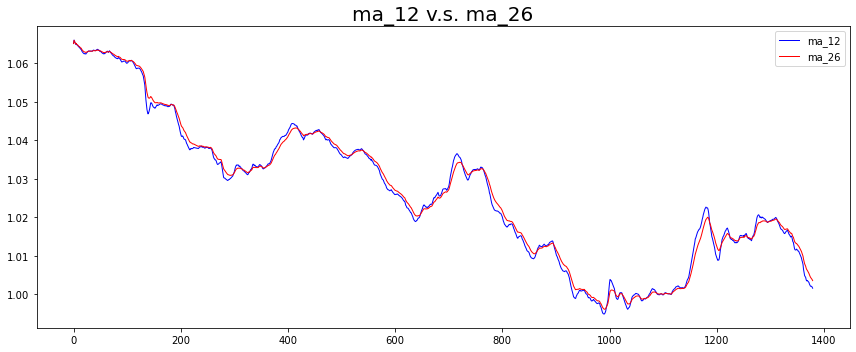

In [48]:
# Main chart - ma_12 and ma_26
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('ma_12 v.s. ma_26', fontsize=20)

ax.plot(index, ma_12_lst, 'b', lw=1, label='ma_12')
ax.plot(index, ma_26_lst, 'r', lw=1, label='ma_26')
ax.legend(loc='best')

fig.tight_layout()

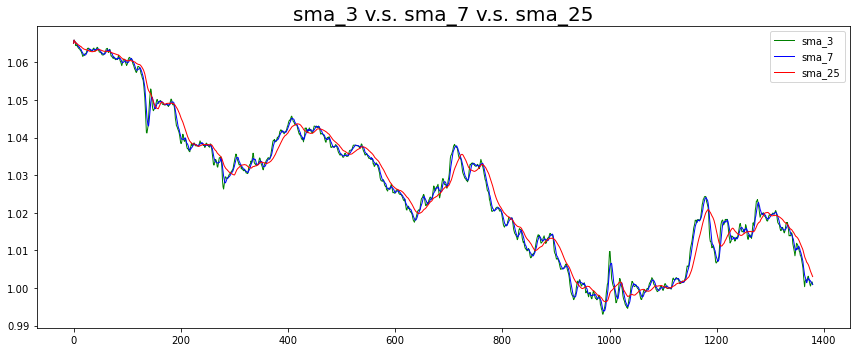

In [49]:
# Main chart - SMA_3 and SMA_7 and SMA_25
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('sma_3 v.s. sma_7 v.s. sma_25', fontsize=20)

ax.plot(index, sma_3_lst, 'g', lw=1, label='sma_3')
ax.plot(index, sma_7_lst, 'b', lw=1, label='sma_7')
ax.plot(index, sma_25_lst, 'r', lw=1, label='sma_25')
ax.legend(loc='best')

fig.tight_layout()

In [50]:
macd_lst = sample_x_df['macd'].loc[sample_x_df['sample_id']==idx].tolist()
macds_lst = sample_x_df['macds'].loc[sample_x_df['sample_id']==idx].tolist()

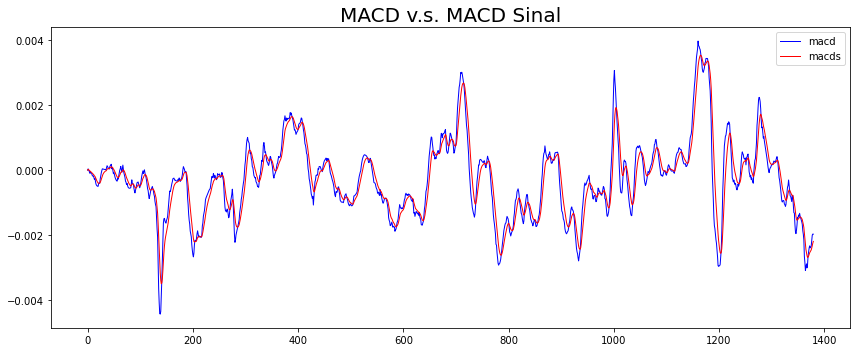

In [51]:
# index chart - MACD and MACDs
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('MACD v.s. MACD Sinal', fontsize=20)

ax.plot(index, macd_lst, 'b', lw=1, label='macd')
ax.plot(index, macds_lst, 'r', lw=1, label='macds')
ax.legend(loc='best')

fig.tight_layout()

In [52]:
macdo_lst = sample_x_df['macdo'].loc[sample_x_df['sample_id']==idx].tolist()

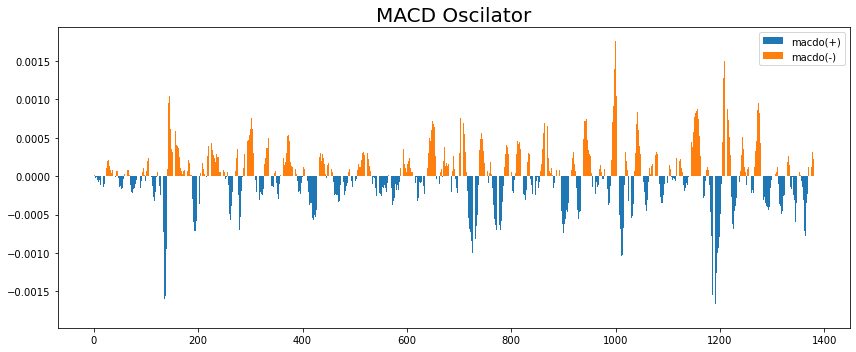

In [53]:
# index chart - MACDo
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('MACD Oscilator', fontsize=20)

ax.bar(index, [0 if i > 0 else i for i in macdo_lst], lw=1, label='macdo(+)')
ax.bar(index, [0 if i < 0 else i for i in macdo_lst], lw=1, label='macdo(-)')
ax.legend(loc='best')

fig.tight_layout()